In [15]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib notebook
%matplotlib notebook


## Problem Setup

The goal is to compare a perfect planar motion device with an optimized device with no y-stage.  

We can find the optimal theta0 for different objective functions for different levels of testing fidelity.  We can optimize for the following within a specified time range:
- minimize absolute Y position lost
- Make the untransformed vehicle CG Acc match as 'best' as possible
    - for Y acc only
    - for X acc only
    - for X and Y acc together
- Same as above but for velocity instead of acceleration




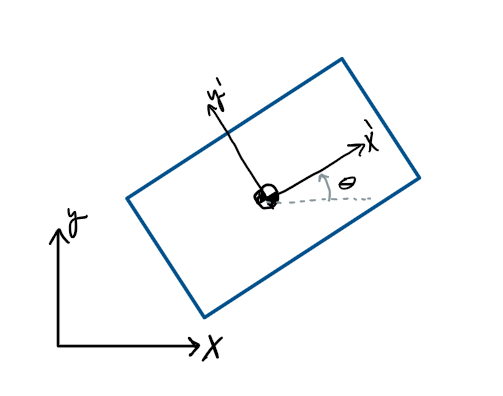

Let $(x,y)$  notate Global coordinates, and $(x',y')$  notate Local Vehicle coordinates.

Because our vehicle accelerations are taken at the CG, we can convert our sensor readings to global accelerations via the following rotation matrix:

$$\left[\begin{array}{l}
A_{x} \\
A_{y}
\end{array}\right]=\left[\begin{array}{cc}
\cos (\theta + \theta_0) & -\sin (\theta + \theta_0) \\
\sin (\theta + \theta_0) & \cos (\theta + \theta_0)
\end{array}\right]\left[\begin{array}{l}
A_{x}^{\prime} \\
A_{y}^{\prime}
\end{array}\right]$$

Note we are allowing for some initial static offset, $\theta_0$ in our equations.  This will be our parameter of interest in optimizing the test configuration

Because the rotation matrix is orthogonal, its transpose is its inverse.  Thus to convert from global back to local, we just have:

$$\left[\begin{array}{l}
A_{x}^{\prime} \\
A_{y}^{\prime}
\end{array}\right]=\left[\begin{array}{cc}
\cos (\theta + \theta_0) & \sin (\theta + \theta_0) \\
-\sin (\theta + \theta_0) & \cos (\theta + \theta_0)
\end{array}\right]\left[\begin{array}{l}
A_{x} \\
0 * A_{y}
\end{array}\right]$$


Once we find an optimized $\theta_0$ for some objective, we then want to look at the acceleration curves that we expect to see at the vehicle CG, assuming that the system can perfectly prescribe $A_x$ and $\theta$ and have no y-motion.  This leads us to use the inverse rotation matrix with zero y-acceleration.  

Expanding the matrix forms, we have 

$$A_{x}^{*}=\cos \left(\theta+\theta_{0}\right)\left[A_{x}^{\prime} \cos \left(\theta+\theta_{0}\right)-A_{y}^{\prime} \sin \left(\theta+\theta_{0}\right)\right]
\\
A_{y}^{*}=-\sin \left(\theta+\theta_{0}\right)\left[A_{x}^{\prime} \cos \left(\theta+\theta_{0}\right)-A_{y}^{\prime} \sin \left(\theta+\theta_{0}\right)\right]
$$

Where $A_{x}^{*},   A_{y}^{*}$  are the expected accelerations at the vehicle from a system with no y-stage and optimized static offset


To "find the static offset that closest matches vehicle CG acceleration"  we want to minimize the error between our approximation and the original. Thus, we want to find 
$$
\frac{\partial}{\partial \theta_0} \cdot \left[(A{x}^{*})^2 - (A_{x}^{\prime})^2\right] = 0
$$

We want to look at different types of Dynamic Yaw data and compare the effect of translating and removing y stage motion.  This is also an excercise in interactive notebook writing


# Import Data

In [16]:
# data = pd.read_csv("8789data.csv")
data = pd.read_csv('9585data.csv')
data['AX'] *= -1
data['AZ'] = np.deg2rad(data['AZ'])

timeStep = 1/20000 # Sensors at 20 khz
time = np.arange(-.05, .3+timeStep, timeStep) 

# Integrate Angular acceleration to get theta
data['WZ'] = integrate.cumtrapz(data["AZ"], time, initial=0)
data['theta'] = integrate.cumtrapz(data["WZ"], time, initial=0)

data['theta'] *= 1

### Let's plot the data from the vehicle accelerometers 


<IPython.core.display.Javascript object>


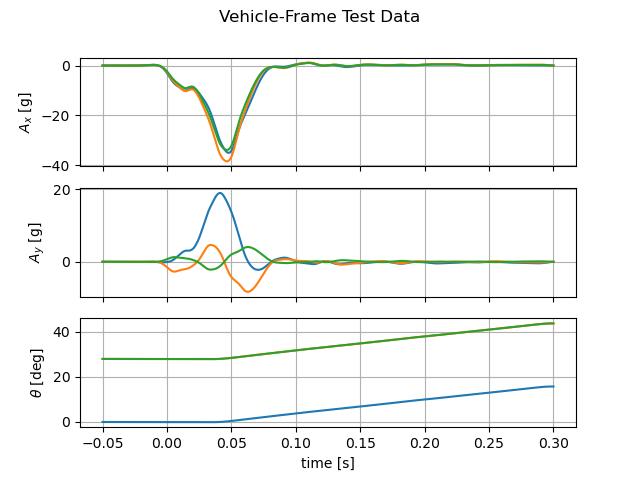

Text(0.5, 0, 'time [s]')

In [17]:
plt.style.use('default')

fig, axs = plt.subplots(3,1, sharex=True)
[ax.grid(which='both') for ax in axs]


fig.suptitle('Vehicle-Frame Test Data')

axs[0].plot(time, data['AX'])
axs[0].set_ylabel('$A_x^{\prime}$ [g]')
axs[1].plot(time, data['AY'])
axs[1].set_ylabel('$A_y^{\prime}$ [g]')
axs[2].plot(time,np.rad2deg(data['theta']))
axs[2].set_ylabel('$\\theta$ [deg]')
axs[2].set_xlabel('time [s]')


# [ax.grid(which='both') for ax in axs]

### And lets plot the transformed data in global coordinates, assuming $\theta_0 = 0$ 

In [18]:
theta0 = np.deg2rad(28)

data['AXglobal'] = cos(data['theta'] + theta0 ) * data["AX"] - sin(data['theta'] + theta0 ) * data["AY"]
data['AYglobal'] = sin(data['theta'] + theta0 ) * data["AX"] + cos(data['theta'] + theta0 ) * data["AY"]


axs[0].plot(time, data['AXglobal'])
axs[0].set_ylabel('$A_x}$ [g]')
axs[1].plot(time, data['AYglobal'])
axs[1].set_ylabel('$A_y$ [g]')
axs[2].plot(time,np.rad2deg(data['theta'] + theta0))


And plot what the vehicle CG would see if we were to simulate this motion with the coresponding $\theta_0$ and no y stage

In [19]:
data['AXapplied'] = cos(data['theta'] + theta0 ) * data["AXglobal"] 
data['AYapplied'] = -sin(data['theta'] + theta0 ) * data["AYglobal"]


axs[0].plot(time, data['AXapplied'])
# axs[0].set_ylabel('$A_x}$ [g]')
axs[1].plot(time, data['AYapplied'])
# axs[1].set_ylabel('$A_y$ [g]')
axs[2].plot(time,np.rad2deg(data['theta'] + theta0))

<IPython.core.display.Javascript object>


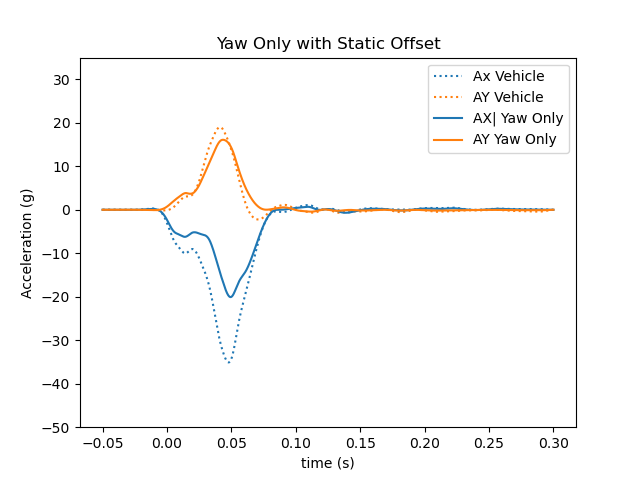

interactive(children=(FloatSlider(value=0.0, description='StaticOffset', max=90.0, min=-90.0, step=2.0), Outpu…

<function __main__.g(StaticOffset)>

In [24]:
plt.figure()
def g(StaticOffset):
    plt.clf()
    theta0 = np.deg2rad(StaticOffset)

    data['AXglobal'] = cos(data['theta'] + theta0 ) * data["AX"] - sin(data['theta'] + theta0 ) * data["AY"]
    data['AYglobal'] = sin(data['theta'] + theta0 ) * data["AX"] + cos(data['theta'] + theta0 ) * data["AY"]

    data['AXnoY'] = cos(data['theta'] + theta0 ) * data["AXglobal"]
    data['AYnoY'] = -sin(data['theta'] + theta0 ) * data["AYglobal"]




    # Vehicle Measurements
    plt.plot(time, data['AX'], color='tab:blue', linestyle=':')
    plt.plot(time, data['AY'], color='tab:orange', linestyle=':')

    # Rotation Matrix to global coordinates
    # plt.plot(time, data['AXglobal'], color='tab:blue', linestyle='-')
    # plt.plot(time, data['AYglobal'], color='tab:orange', linestyle='-')

    # Plot what the vehicle will see with no Y
    plt.plot(time, data['AXnoY'], color='tab:blue', linestyle='-')
    plt.plot(time, data['AYnoY'], color='tab:orange', linestyle='-')

    plt.legend(['AX', 'AY', 'AXG', 'AYG', 'AXnoY', 'AYnoY'])
    plt.legend(['Ax Vehicle', 'AY Vehicle','AX| Yaw Only', 'AY Yaw Only'])
    
    plt.ylim([-50,35])
    plt.title('Yaw Only with Static Offset')
    plt.ylabel('Acceleration (g)')
    plt.xlabel('time (s)')
    plt.show()
interact(g, StaticOffset=widgets.FloatSlider(min=-90, max=90, step=2, value=0))

In [ ]:
def objective_fun(StaticOffset):
    data['AXglobal'] = cos(data['theta'] + theta0 ) * data["AX"] - sin(data['theta'] + theta0 ) * data["AY"]
    data['AYglobal'] = sin(data['theta'] + theta0 ) * data["AX"] + cos(data['theta'] + theta0 ) * data["AY"]

    data['AXnoY'] = cos(data['theta'] + theta0 ) * data["AXglobal"]
    data['AYnoY'] = -sin(data['theta'] + theta0 ) * data["AXglobal"]
    
    res = 

<IPython.core.display.Javascript object>


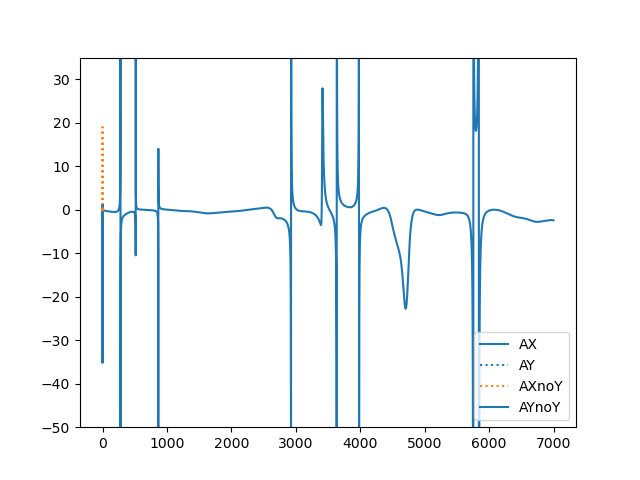

In [142]:
data['accAngle'] = np.rad2deg(np.arctan(data['AY'] / data['AX']))
plt.plot(time, data['accAngle'], 'o')
plt.show()

plt.figure()
plt.plot(data['AY'] / data['AX'])


Note: you may need to restart the kernel to use updated packages.



CommandNotFoundError: No command 'conda freeze'.

